In [1]:
!pip install transformers torch


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Path to the consolidated version
dataset_path = "AMUSED_consolidated.xlsx"

# Load sheets
claims = pd.read_excel(dataset_path, sheet_name="claims")
posts = pd.read_excel(dataset_path, sheet_name="posts")
comments = pd.read_excel(dataset_path, sheet_name="comments")
user_features = pd.read_excel(dataset_path, sheet_name="user_features")

# Example: Get all posts for a claim
claim_id = 1
related_posts = posts[posts["claim_id"] == claim_id]

# Example: Get all comments for a post
post_id = related_posts.iloc[0]["post_id"]
related_comments = comments[comments["post_id"] == post_id]

# Merge posts and comments if you want both labels together
df = pd.merge(
    related_posts,
    related_comments,
    left_on="post_id",
    right_on="post_id",
    suffixes=("_x", "_y")  # _x = post label, _y = comment label
)




In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df["label_x"] = label_encoder.fit_transform(df["label_x"])
df["label_y"] = label_encoder.fit_transform(df["label_y"])

# View result
print(df.head())

In [5]:
# Step 3: Prepare data for stance detection using XLM-Roberta
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

class StanceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [6]:
# Step 4: Split the data
texts = df['comment'].tolist()  
labels = df['label_y'].tolist() 
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = StanceDataset(X_train, y_train, tokenizer, max_length=128)
test_dataset = StanceDataset(X_test, y_test, tokenizer, max_length=128)


In [7]:
from transformers import EarlyStoppingCallback
from transformers import XLMRobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(set(labels)), 
    hidden_dropout_prob=0.2  
)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,  
    lr_scheduler_type='linear',  
    gradient_accumulation_steps=2,  
    save_total_limit=2,  
    load_best_model_at_end=True  
)

# Step 3: Define a custom metric function for evaluation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1': f1_score(p.label_ids, preds, average='weighted')
    }

# Step 4: Create the Trainer with early stopping and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=test_dataset,  
    compute_metrics=compute_metrics,  
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  
)

trainer.train()

# Step 6: Save the trained model
model.save_pretrained('stance_model')



model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.949900,0.951577,0.609817,0.586483
2,0.866500,0.804867,0.657961,0.649824
4,0.729600,0.806927,0.672593,0.669863


In [8]:
# Step 6: Stance detection on new data
def predict_stance(texts):
    model.eval()  
    predictions = []
    for text in texts:
        if pd.isnull(text) or not isinstance(text, str):  
            predictions.append(-1)  
            continue

        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_attention_mask=True,
            return_tensors='pt',
            padding='max_length',
            truncation=True
        )
        
        input_ids = encoding['input_ids'].to(model.device)
        attention_mask = encoding['attention_mask'].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        predictions.append(prediction)
    return predictions

df['comment'].fillna('', inplace=True) 

df['stance_count'] = predict_stance(df['comment'].tolist())

<ipython-input-8-d83e4ecdf0d1>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['comment'].fillna('', inplace=True) # Option 1: Replace NaN with an empty string


In [9]:
!pip install textstat spacy nltk empath-client
!python -m spacy download en_core_web_sm


ERROR: Could not find a version that satisfies the requirement empath-client (from versions: none)
ERROR: No matching distribution found for empath-client
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
#features_df.head()

In [11]:
# Step 8: Prepare for Fake News Detection
features = df[['title', 'stance_count', 'isverified','followers', 'followings','bio', 'timestamp','likescount']]  

In [12]:

!pip install scikit-learn # Install the necessary package
from sklearn.preprocessing import StandardScaler

In [13]:
# Step 9: Apply PCA and Chi-Square for dimensionality reduction

# 2. Convert 'title' to numerical representation using Label Encoding
le = LabelEncoder()
features_num['title'] = le.fit_transform(features_num['title'])

if features_num['isverified'].dtype == bool:
    features_num['isverified'] = features_num['isverified'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_num.values)

# 5. Apply PCA

pca = PCA(n_components)  
X_pca = pca.fit_transform(X_scaled)  

# 6. Apply Chi-Square (no change needed here if 'label_y' is numerical)

chi2_selector = SelectKBest() 
X_chi2 = chi2_selector.fit_transform(features_num.values, df['label_y'])

In [14]:
# Step 10: Hybrid Model - DistilBERT + Bi-GRU
class FakeNewsDetectionModel(nn.Module):
    def __init__(self):
        super(FakeNewsDetectionModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.gru = nn.GRU(768, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_output.last_hidden_state
        gru_output, _ = self.gru(hidden_states)
        pooled_output = gru_output[:, -1, :]
        output = self.fc(pooled_output)
        return self.sigmoid(output)

In [15]:
# Step 11: Train the Hybrid Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [16]:
# Define a custom Dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['comment'], df['label_x'], test_size=0.2, random_state=42
)

In [18]:
# Create DataLoaders
train_dataset = FakeNewsDataset(X_train.tolist(), y_train.tolist())
test_dataset = FakeNewsDataset(X_test.tolist(), y_test.tolist())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
# Define the Hybrid Model: DistilBERT + Bi-GRU
class HybridModel(nn.Module):
    def __init__(self, hidden_size=128, num_classes=2):
        super(HybridModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size, hidden_size=hidden_size,
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_output.last_hidden_state  
        _, hidden = self.gru(hidden_states)  
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)  
        output = self.fc(hidden) 
        return output

In [20]:
# Initialize the model, loss function, and optimizer
model = HybridModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [21]:
# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [22]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.5881
Epoch 2, Loss: 0.5003
Epoch 3, Loss: 0.3939
Epoch 4, Loss: 0.3012
Epoch 5, Loss: 0.2432
Epoch 6, Loss: 0.2055
Epoch 7, Loss: 0.1751
Epoch 8, Loss: 0.1591
Epoch 9, Loss: 0.1398
Epoch 10, Loss: 0.1293


In [28]:
for epoch in range(5):  
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.1211
Epoch 2, Loss: 0.1085
Epoch 3, Loss: 0.1071
Epoch 4, Loss: 0.0948
Epoch 5, Loss: 0.0957


In [29]:
# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


In [30]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.7052
Confusion Matrix:
[[1296 1017]
 [ 857 3186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58      2313
           1       0.76      0.79      0.77      4043

    accuracy                           0.71      6356
   macro avg       0.68      0.67      0.68      6356
weighted avg       0.70      0.71      0.70      6356



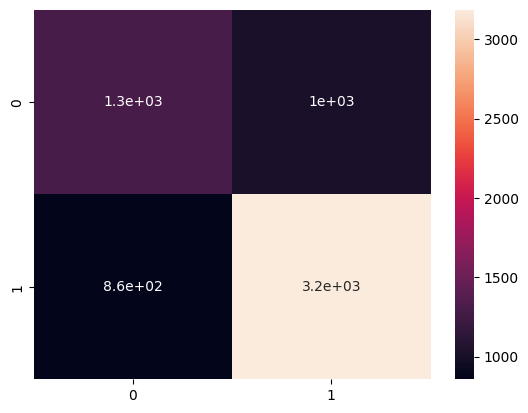

In [31]:
# Step 13: Plotting graphs
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.show()

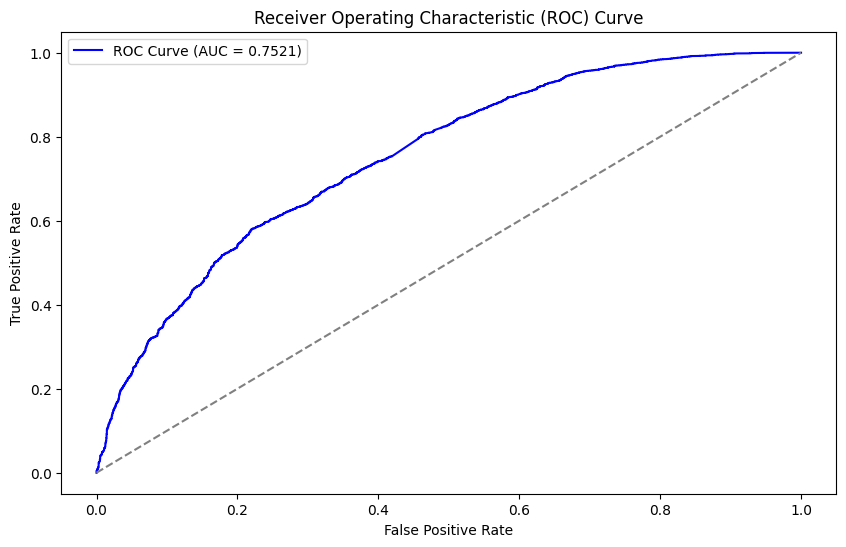

In [26]:
# Import necessary libraries
!pip install scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import torch.nn.functional as F
# ... your existing code ...


# Evaluation
model.eval()
y_pred = []
y_true = []
y_probs = []  # Initialize y_probs to store all probabilities

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)

        # Get probabilities before taking argmax for predictions
        probs = F.softmax(outputs, dim=1)
        y_probs.extend(probs[:, 1].cpu().numpy()) # Probabilities for the positive class

        _, preds = torch.max(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# ... rest of your code ...

# Calculate the ROC Curve and AUC (after the loop)
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

# ... rest of your plotting code ...

# Plot the ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [27]:
import joblib
import zipfile

# Save the trained BiGRU model
torch.save(model.state_dict(), 'fake_news_model.pth')

# Save the tokenizer, PCA, and Chi-Square selectors
joblib.dump(tokenizer, 'distilbert_tokenizer.pkl')
joblib.dump(pca, 'pca_selector.pkl')
joblib.dump(chi2_selector, 'chi2_selector.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Create a zip file and add the saved files
with zipfile.ZipFile('fake_news_model_components.zip', 'w') as zipf:
    zipf.write('fake_news_model.pth')
    zipf.write('distilbert_tokenizer.pkl')
    zipf.write('pca_selector.pkl')
    zipf.write('chi2_selector.pkl')
    zipf.write('label_encoder.pkl')

print("Model and components saved to fake_news_model_components.zip successfully!")

Model and components saved to fake_news_model_components.zip successfully!


In [ ]:
# Install LIME
!pip install lime

import torch
import numpy as np
from lime.lime_text import LimeTextExplainer

# Class names according to your dataset
class_names = ["Real", "Fake"]  # Change if your labels differ

# Prediction function for LIME
def predict_proba(texts):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for text in texts:
            encoding = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs[0])
    return np.array(all_probs)

# Initialize LIME Explainer
explainer = LimeTextExplainer(class_names=class_names)

# Example text for explanation
sample_text = "Twitter has unbanned recently."

# Generate explanation
exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

# Show explanation in notebook
exp.show_in_notebook(text=sample_text)
